# Lab 3: Binary Classification with Neural Networks
# Objective: Explore how neural network architecture and optimizer choice affect the ability to learn non-linear decision boundaries on a 2-D circular classification dataset.
# Submitted By: Rohan Shrestha (ACE079BCT048)

---

### Neural Networks

A neural network is a parametric function composed of stacked linear transformations and non-linear activations:

$$f(x) = \sigma(W_L \cdot \sigma(W_{L-1} \cdots \sigma(W_1 x + b_1) \cdots + b_{L-1}) + b_L)$$

Where $\sigma$ is an activation function, $W_i$ are weight matrices, and $b_i$ are bias vectors.

**Without $\sigma$ (no activation):** Every composition of linear functions is itself linear — stacking many layers produces exactly the same family of functions as a single linear layer. No matter how deep, the decision boundary is always a hyperplane.

**With $\sigma$ (e.g. ReLU):** Non-linearity is introduced at every layer. The Universal Approximation Theorem guarantees that a sufficiently wide single hidden layer can approximate any continuous function on a compact domain. In practice, depth + width + non-linearity together enable rich, curved decision boundaries.

### The Circles Dataset

Our dataset contains two features (X1, X2) representing 2-D coordinates, with a binary label (0/1) distinguishing an inner circle from an outer ring. This is a canonical benchmark for testing non-linear separability — it is **impossible** to separate with any straight line or hyperplane.

---
## About the Dataset and Pipeline

| Step | What we do |
|---|---|
| Load & inspect | `pandas.read_csv`, `head()`, `describe()` |
| Clean | Drop NaN rows, coerce to numeric |
| Features | `X = [X1, X2]`, `y = label` |
| Convert | NumPy → `torch.float32` tensors |
| Visualize | Scatter plot colored by label |
| Split | `train_test_split(test_size=0.2, random_state=42)` |
| Device | `cuda` if available, else `cpu` |
| Models | V0 (linear), V1 (wider linear), V2 (ReLU) |
| Train | `BCEWithLogitsLoss` + SGD, print every 10 epochs |
| Evaluate | Decision boundaries + loss/accuracy curves |
| Adam | Repeat with Adam optimizer, compare convergence |

In [52]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split

---
## Data Retrieval & Inspection

We load the circles dataset using Pandas and perform an initial inspection. `head()` shows the first few rows to confirm structure, while `describe()` provides summary statistics (count, mean, std, min/max) to check for obvious anomalies or scale issues before preprocessing.

In [53]:
# Reading data using Pandas
data = pandas.read_csv("./circles_binary_classification.csv")

# Check to see if the data is loaded correctly
data.head(5)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [54]:
# Summary of the data
data.describe()

,X1,X2,label
count,1000.000000,1000.000000,1000.00000
mean,-0.000448,-0.000804,0.50000
std,0.639837,0.641156,0.50025
min,-1.059502,-1.067768,0.00000
25%,-0.619251,-0.612176,0.00000
50%,0.008762,-0.003949,0.50000
75%,0.621933,0.624822,1.00000
max,1.033712,1.036004,1.00000


---
## Data Cleaning & Feature Engineering

**Cleaning steps:**
- `dropna()` removes any rows with missing values — keeps data integrity without guessing substitution values for coordinate data
- `pd.to_numeric(..., errors='coerce')` forces all columns to numeric, replacing anything non-numeric with NaN, which is then eliminated by the prior `dropna()`

**Feature design:**
- `X = data[["X1", "X2"]]` — both spatial coordinates form the 2-D input feature matrix
- `y = data["label"]` — binary target (0 = inner circle, 1 = outer ring)

**Tensor conversion:**
- We convert to `torch.float32` tensors — the required dtype for PyTorch's `nn.Linear` layers
- `torch.isnan(...).any()` verifies no NaN values survived after cleaning, confirming tensor integrity before training

In [55]:
# Data cleaning and preprocessing

# remove missing values rows
data = data.dropna()

# force the data to be numeric
data = data.apply(pandas.to_numeric, errors='coerce')

# feature engineering
X = data[["X1", "X2"]]
Y = data["label"]

In [56]:
# converting to Tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
Y_tensor = torch.tensor(Y.values, dtype=torch.float32)

# Check cleaned data
torch.isnan(X_tensor).any().item()

False

---
## Data Visualization

Before training, we scatter-plot X1 vs X2 colored by the binary label. This is an essential diagnostic step — it reveals the **geometric structure of the problem** and immediately tells us what kind of model will be needed.

If the classes are linearly separable (a line could divide red from blue), a linear model suffices. If not, we need non-linear capacity — this is the entire motivation for activation functions in Task 2.

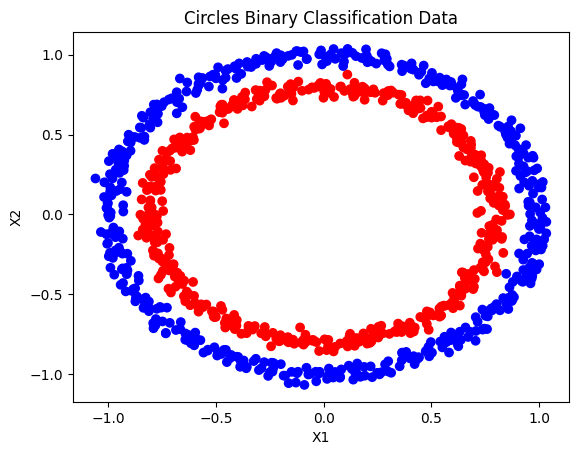

In [57]:
# Data visualization
plt.scatter(X_tensor[:, 0], X_tensor[:, 1], c=Y_tensor, cmap="bwr")
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Circles Binary Classification Data")
plt.show()

**Observation — Data Visualization:**
The scatter plot reveals two clearly **concentric rings** — the inner circle (one class) surrounded by the outer ring (the other class). No straight line can separate these classes. This confirms our hypothesis: a linear classifier will fail entirely on this dataset, and **non-linear activation functions are mandatory** for the model to learn this structure.

In [58]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [59]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)

# Move tensors to device
X_train = X_train.to(device)
X_test = X_test.to(device)
Y_train = Y_train.to(device)
Y_test = Y_test.to(device)

print(f"X_train device: {X_train.device}")
print(f"X_test device: {X_test.device}")

X_train device: cpu
X_test device: cpu


---
## Train/Test Split

**Device-agnostic code:** We check for CUDA (GPU) availability at runtime. If a GPU is present, all tensors and models are moved there, enabling significant speedups for large batches. The code falls back to CPU gracefully — this is best practice for reproducible, portable notebooks.

**Train/test split:**
- `test_size=0.2` reserves 20% of data for evaluation, ensuring the model never sees test samples during training
- `random_state=42` makes the split deterministic and reproducible
- After splitting, both sets are moved to the target device — an important step often forgotten that causes device mismatch errors during forward passes

**Why separate train and test?**
Evaluating on training data gives an overly optimistic picture. The test set provides an unbiased estimate of how the model will perform on genuinely unseen data — the only metric that matters for real-world deployment.

In [60]:
class ModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 5),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.net(x)

# 4. instance of the model and send it to target device
model_0 = ModelV0().to(device)
model_0

ModelV0(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [61]:
class ModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 15),
            nn.Linear(15, 15),
            nn.Linear(15, 1)
        )

    def forward(self, x):
        return self.net(x)

# 4. instance of the model and send it to target device
model_1 = ModelV1().to(device)
model_1

ModelV1(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=15, bias=True)
    (1): Linear(in_features=15, out_features=15, bias=True)
    (2): Linear(in_features=15, out_features=1, bias=True)
  )
)

In [62]:
class ModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.net(x)
    
# 4. instance of the model and send it to target device
model_2 = ModelV2().to(device)
model_2

ModelV2(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)

---
## Model Architectures — Theory & Design Rationale

We define three models with identical input/output dimensions (2 → 1) but different internal structures:

| Model | Architecture | Activation | Expressiveness |
|---|---|---|---|
| **V0** | 2 → 5 → 1 | None | Linear only |
| **V1** | 2 → 15 → 15 → 1 | None | Linear only (wider/deeper) |
| **V2** | 2 → 64 → 64 → 10 → 1 | ReLU between layers | Non-linear |

### Why Activation Functions Are Essential for Non-Linear Data

**The Linear Algebra Problem:**
Without activation functions, a neural network of any depth is equivalent to a single linear transformation:

$$W_3(W_2(W_1 x + b_1) + b_2) + b_3 = W' x + b'$$

No matter how many layers you stack, composition of linear maps is still a linear map. The model can only ever learn a hyperplane boundary — completely useless for our concentric circles.

**ReLU to the Rescue:**
The Rectified Linear Unit is defined as $\text{ReLU}(x) = \max(0, x)$. It is:
- **Non-linear:** breaks the linear algebraic composition chain
- **Piecewise linear:** creates "kinks" that, when composed through layers, can approximate curves
- **Computationally cheap:** just a threshold — no expensive exponentials
- **Gradient-friendly:** derivative is 0 or 1, minimizing vanishing gradient issues

With ReLU activations, each neuron partitions its input space into activated and non-activated regions. The composition of these partitions across many neurons and layers creates the complex, curved boundary needed to separate concentric circles.

### Loss Function: BCEWithLogitsLoss

For binary classification we use `nn.BCEWithLogitsLoss`, which combines:
1. A **sigmoid** activation: $\sigma(z) = \frac{1}{1 + e^{-z}}$ (converts raw logit to probability)
2. **Binary Cross-Entropy**: $\mathcal{L} = -[y \log(\hat{p}) + (1-y)\log(1-\hat{p})]$

Why not use `BCELoss` with explicit sigmoid? `BCEWithLogitsLoss` is numerically more stable as it avoids computing sigmoid then log separately. The model outputs raw logits; the loss handles conversion internally.

**Accuracy** is computed separately using `torch.round(torch.sigmoid(logits))` — mapping logits to 0/1 predictions by thresholding at 0.5 probability.

### Epoch Count Rationale

| Model | Optimizer | Epochs | Rationale |
|---|---|---|---|
| V0 | SGD | 100 | Linear model — converges quickly or doesn't at all |
| V1 | SGD | 1000 | More parameters but still linear — needs many steps to find plateau |
| V2 | SGD | 700 | ReLU enables learning; 700 is sufficient to demonstrate convergence |
| V0 | Adam | 100 | Adam's adaptive lr converges faster — same epochs as SGD for fair comparison |
| V1 | Adam | 100 | Adam reaches plateau much sooner — 1000 epochs would be wasteful |
| V2 | Adam | 700 | Adam converges within ~200 epochs; 700 shows full learning curve |

The epoch choices deliberately highlight the fundamental difference: for linear models the ceiling is architectural, not optimizer-dependent. For the ReLU model, Adam's efficiency is clearly visible.

In [63]:
def binary_accuracy_from_logits(logits, y_true):
    probs = torch.sigmoid(logits)
    preds = torch.round(probs)            # 0/1
    correct = (preds == y_true).float().mean()
    return correct.item()

In [64]:
def train_model(model, X_train, y_train, X_test, y_test,
                epochs=100, lr=0.1, print_every=10, optimizer_name="SGD"):
    """
    Trains and evaluates one binary-classification model using:
      - BCEWithLogitsLoss (raw logits)
      - SGD or Adam optimizer (controlled by optimizer_name)

    Returns:
      results dict with train/test losses and accuracies per epoch
    """
    # --- Reinitialize model parameters (important between experiments) ---
    def reset_weights(m):
        if hasattr(m, "reset_parameters"):
            m.reset_parameters()
    model.apply(reset_weights)

    model = model.to(device)
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    # Ensure target shape/dtype for BCEWithLogitsLoss
    y_train = y_train.view(-1, 1).float()
    y_test = y_test.view(-1, 1).float()

    loss_fn = nn.BCEWithLogitsLoss()

    if optimizer_name.lower() == "adam":
        optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    else:  # default: SGD
        optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in range(epochs):
        # -------------------- Train --------------------
        model.train()
        train_logits = model(X_train)                    # raw logits
        train_loss = loss_fn(train_logits, y_train)
        train_acc = binary_accuracy_from_logits(train_logits, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # -------------------- Eval ---------------------
        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test)                  # raw logits
            test_loss = loss_fn(test_logits, y_test)
            test_acc = binary_accuracy_from_logits(test_logits, y_test)

        # store history
        results["train_loss"].append(train_loss.item())
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss.item())
        results["test_acc"].append(test_acc)

        # print progress every N epochs
        if epoch % print_every == 0 or epoch == epochs - 1:
            print(
                f"Epoch {epoch:4d}/{epochs-1} | "
                f"Train Loss: {train_loss.item():.4f}, Train Acc: {train_acc:.4f} | "
                f"Test Loss: {test_loss.item():.4f}, Test Acc: {test_acc:.4f}"
            )

    return results

In [65]:
def plot_train_test_curves(results, title="Model"):
    epochs = range(1, len(results["train_loss"]) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    axes[0].plot(epochs, results["train_loss"], label="Train Loss")
    axes[0].plot(epochs, results["test_loss"], label="Test Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title(f"{title} - Loss")
    axes[0].legend()

    # Accuracy
    axes[1].plot(epochs, results["train_acc"], label="Train Acc")
    axes[1].plot(epochs, results["test_acc"], label="Test Acc")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title(f"{title} - Accuracy")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [66]:
def predict_binary(model, X):
    """
    Returns:
      probs: (N,1) probabilities
      preds: (N,1) predicted labels {0,1}
    """
    model.eval()
    with torch.inference_mode():
        X = X.to(device).float()
        logits = model(X)                  # raw logits
        probs = torch.sigmoid(logits)      # convert to probs
        preds = torch.round(probs)         # 0/1
    return probs, preds

In [67]:
def plot_decision_boundary(model, X, y, title="Decision Boundary", ax=None):
    """
    Plots model decision boundary over a 2-D feature scatter.
    X: (N, 2) float tensor  |  y: (N,) or (N,1) tensor with labels 0/1
    Pass ax to draw into an existing subplot axis (no plt.show() called).
    """
    model.eval()
    X_np = X.detach().cpu().numpy()
    y_np = y.detach().cpu().numpy().reshape(-1).astype(int)

    # Build a dense grid that covers the data
    x_min, x_max = X_np[:, 0].min() - 0.1, X_np[:, 0].max() + 0.1
    y_min, y_max = X_np[:, 1].min() - 0.1, X_np[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)

    with torch.inference_mode():
        logits = model(grid).view(-1)
        zz = torch.round(torch.sigmoid(logits)).cpu().numpy().reshape(xx.shape)

    standalone = ax is None
    if standalone:
        fig, ax = plt.subplots(figsize=(7, 5))

    ax.contourf(xx, yy, zz, cmap="bwr", alpha=0.3)
    ax.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap="bwr",
               s=15, edgecolors="k", linewidths=0.3)
    ax.set_title(title)
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")

    if standalone:
        plt.tight_layout()
        plt.show()

---
## SGD Experiments — Baseline Models

We now train all three model architectures using **Stochastic Gradient Descent (SGD)** with `lr = 0.1`.

**SGD Update Rule:**
$$\theta \leftarrow \theta - \eta \cdot \nabla_\theta \mathcal{L}$$

SGD applies the same fixed learning rate $\eta$ to every parameter at every step. It is simple, well-understood, and serves as our baseline before exploring adaptive optimizers.

For each model we show:
1. **Untrained decision boundary** (random initial weights) — establishes the starting point
2. **Training log** every 10 epochs — shows convergence behaviour
3. **Loss & accuracy curves** — reveals whether the model is learning
4. **Trained decision boundary** — shows the final learned separation

### Experiment 1 — ModelV0: 2 → 5 → 1 (No Activation, SGD)

=== ModelV0 — UNTRAINED ===


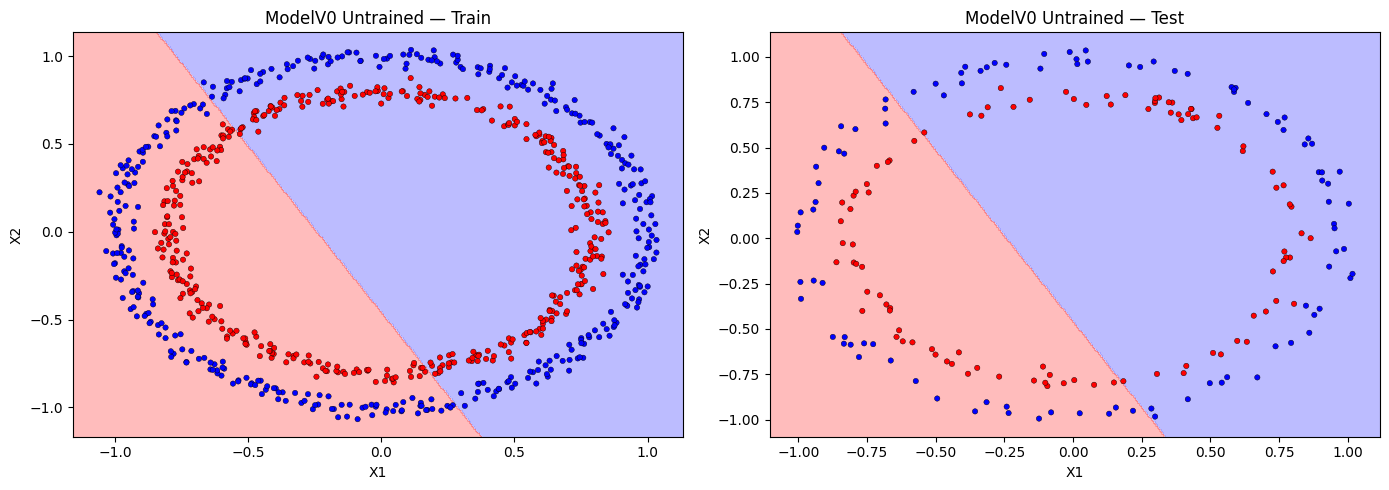

Epoch    0/99 | Train Loss: 0.7554, Train Acc: 0.5000 | Test Loss: 0.7703, Test Acc: 0.5000
Epoch   10/99 | Train Loss: 0.7160, Train Acc: 0.5487 | Test Loss: 0.7272, Test Acc: 0.5450
Epoch   20/99 | Train Loss: 0.7024, Train Acc: 0.5537 | Test Loss: 0.7109, Test Acc: 0.5150
Epoch   30/99 | Train Loss: 0.6974, Train Acc: 0.5288 | Test Loss: 0.7042, Test Acc: 0.5100
Epoch   40/99 | Train Loss: 0.6955, Train Acc: 0.5200 | Test Loss: 0.7011, Test Acc: 0.5150
Epoch   50/99 | Train Loss: 0.6946, Train Acc: 0.5150 | Test Loss: 0.6995, Test Acc: 0.4800
Epoch   60/99 | Train Loss: 0.6942, Train Acc: 0.5100 | Test Loss: 0.6985, Test Acc: 0.4700
Epoch   70/99 | Train Loss: 0.6940, Train Acc: 0.5075 | Test Loss: 0.6979, Test Acc: 0.4750
Epoch   80/99 | Train Loss: 0.6938, Train Acc: 0.5038 | Test Loss: 0.6975, Test Acc: 0.4850
Epoch   90/99 | Train Loss: 0.6937, Train Acc: 0.5063 | Test Loss: 0.6972, Test Acc: 0.4800
Epoch   99/99 | Train Loss: 0.6936, Train Acc: 0.5038 | Test Loss: 0.6969, Test 

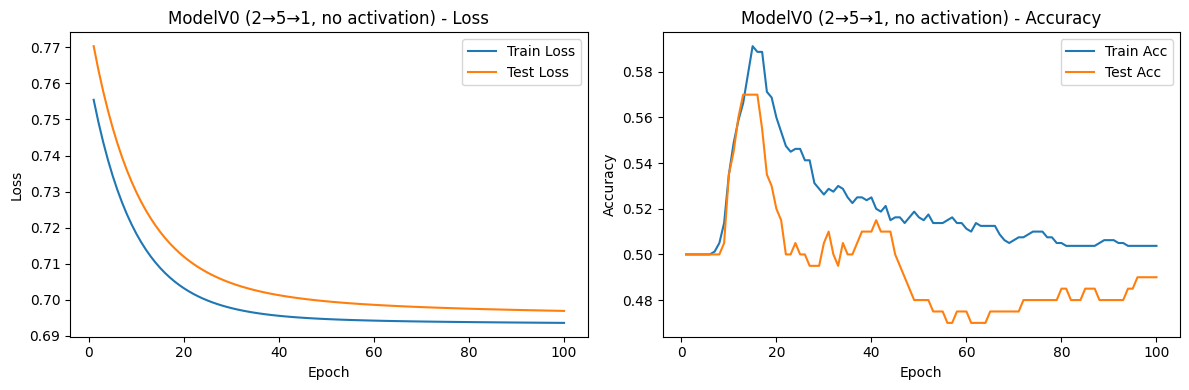

=== ModelV0 — TRAINED ===


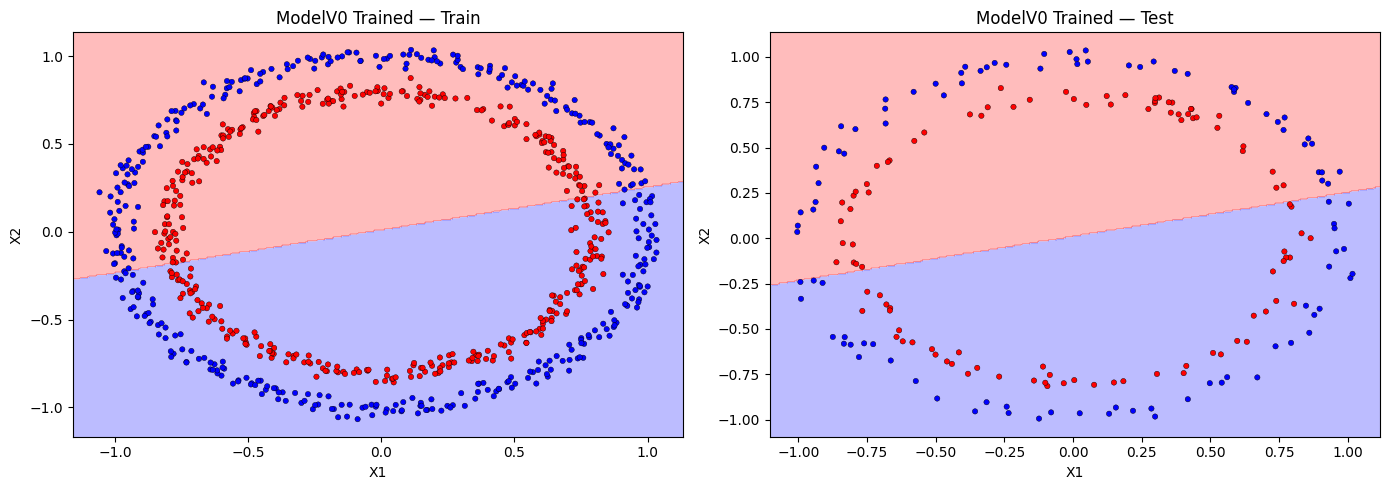

In [68]:
# ── ModelV0: 2 → 5 → 1 (no activation) ──────────────────────────────────────
model_v0 = ModelV0().to(device)

# Untrained decision boundaries
print("=== ModelV0 — UNTRAINED ===")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_decision_boundary(model_v0, X_train, Y_train, title="ModelV0 Untrained — Train", ax=axes[0])
plot_decision_boundary(model_v0, X_test,  Y_test,  title="ModelV0 Untrained — Test",  ax=axes[1])
plt.tight_layout()
plt.show()

# Train (~100 epochs is typically enough for this simple linear model)
results_v0 = train_model(model_v0, X_train, Y_train, X_test, Y_test, epochs=100, lr=0.1)

# Loss & accuracy curves
plot_train_test_curves(results_v0, title="ModelV0 (2→5→1, no activation)")

# Trained decision boundaries
print("=== ModelV0 — TRAINED ===")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_decision_boundary(model_v0, X_train, Y_train, title="ModelV0 Trained — Train", ax=axes[0])
plot_decision_boundary(model_v0, X_test,  Y_test,  title="ModelV0 Trained — Test",  ax=axes[1])
plt.tight_layout()
plt.show()

**Observation — ModelV0 (SGD, No Activation):**
- The trained decision boundary is a **single straight diagonal line** — exactly what we expect from a depth-1 linear model (2→5→1 collapses to a single linear transform)
- Train and test accuracy hover around **~50 %** — equivalent to random guessing on balanced data
- The loss curve barely moves; the model has no capacity to reduce loss beyond the linear limit
- **Conclusion:** Depth and width without non-linearity provide zero benefit for this problem. A 2→5→1 linear network is mathematically identical to logistic regression.

---
### Experiment 2 — ModelV1: 2 → 15 → 15 → 1 (No Activation, SGD)

=== ModelV1 — UNTRAINED ===


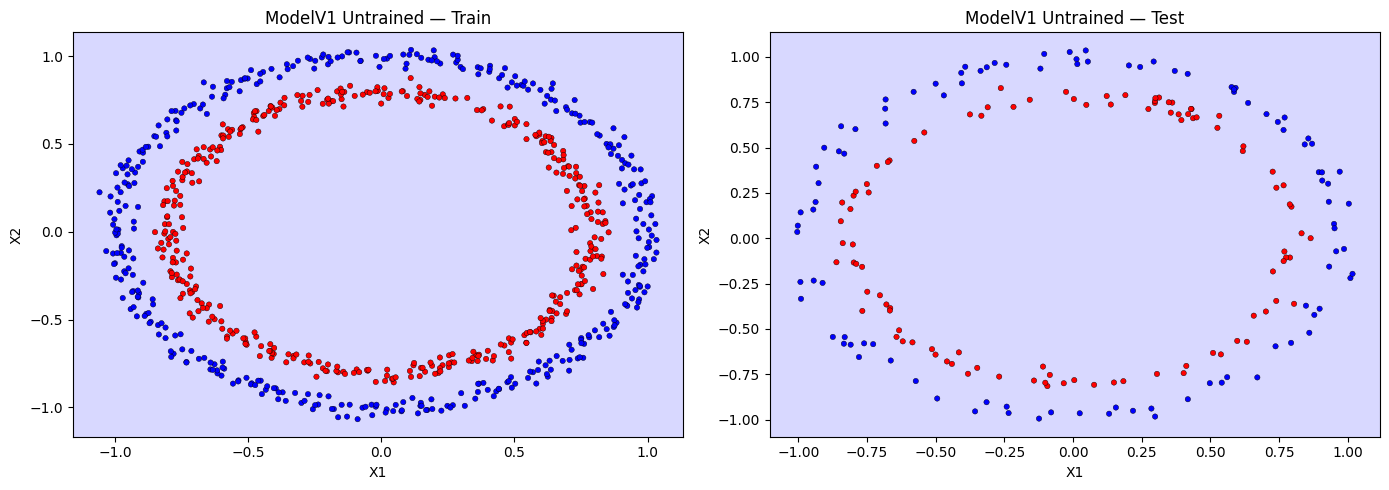

Epoch    0/999 | Train Loss: 0.6934, Train Acc: 0.5188 | Test Loss: 0.6925, Test Acc: 0.5350
Epoch   10/999 | Train Loss: 0.6933, Train Acc: 0.5125 | Test Loss: 0.6928, Test Acc: 0.5200
Epoch   20/999 | Train Loss: 0.6932, Train Acc: 0.5100 | Test Loss: 0.6930, Test Acc: 0.4950
Epoch   30/999 | Train Loss: 0.6931, Train Acc: 0.5025 | Test Loss: 0.6932, Test Acc: 0.5300
Epoch   40/999 | Train Loss: 0.6931, Train Acc: 0.5088 | Test Loss: 0.6934, Test Acc: 0.4650
Epoch   50/999 | Train Loss: 0.6931, Train Acc: 0.5113 | Test Loss: 0.6935, Test Acc: 0.4700
Epoch   60/999 | Train Loss: 0.6930, Train Acc: 0.5088 | Test Loss: 0.6937, Test Acc: 0.4650
Epoch   70/999 | Train Loss: 0.6930, Train Acc: 0.5175 | Test Loss: 0.6938, Test Acc: 0.4750
Epoch   80/999 | Train Loss: 0.6930, Train Acc: 0.5100 | Test Loss: 0.6939, Test Acc: 0.4700
Epoch   90/999 | Train Loss: 0.6930, Train Acc: 0.5125 | Test Loss: 0.6940, Test Acc: 0.4650
Epoch  100/999 | Train Loss: 0.6930, Train Acc: 0.5100 | Test Loss: 0.

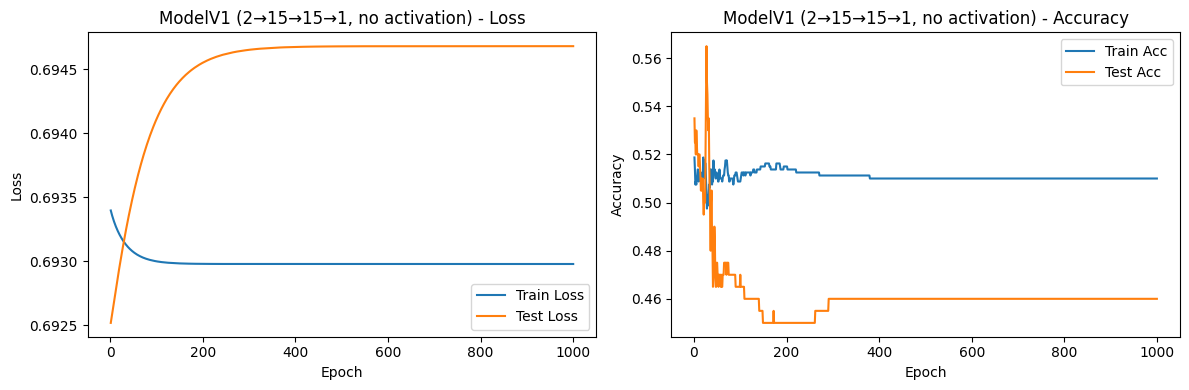

=== ModelV1 — TRAINED ===


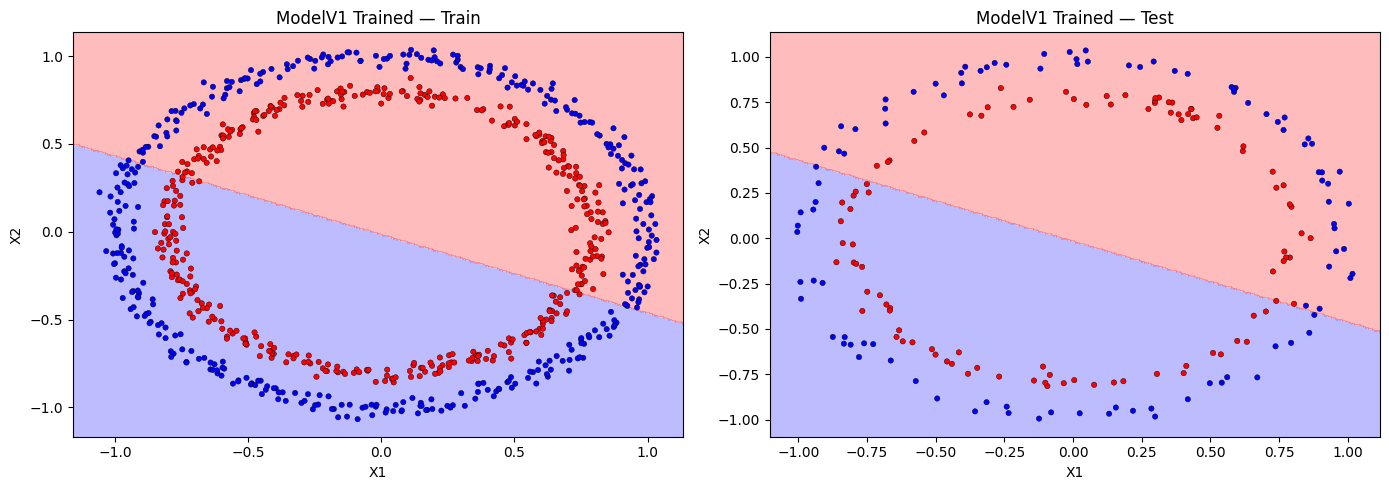

In [69]:
# ── ModelV1: 2 → 15 → 15 → 1 (no activation) ────────────────────────────────
model_v1 = ModelV1().to(device)

# Untrained decision boundaries
print("=== ModelV1 — UNTRAINED ===")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_decision_boundary(model_v1, X_train, Y_train, title="ModelV1 Untrained — Train", ax=axes[0])
plot_decision_boundary(model_v1, X_test,  Y_test,  title="ModelV1 Untrained — Test",  ax=axes[1])
plt.tight_layout()
plt.show()

# Train (needs ~1000 epochs without non-linearity to start separating)
results_v1 = train_model(model_v1, X_train, Y_train, X_test, Y_test, epochs=1000, lr=0.1)

# Loss & accuracy curves
plot_train_test_curves(results_v1, title="ModelV1 (2→15→15→1, no activation)")

# Trained decision boundaries
print("=== ModelV1 — TRAINED ===")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_decision_boundary(model_v1, X_train, Y_train, title="ModelV1 Trained — Train", ax=axes[0])
plot_decision_boundary(model_v1, X_test,  Y_test,  title="ModelV1 Trained — Test",  ax=axes[1])
plt.tight_layout()
plt.show()

**Observation — ModelV1 (SGD, No Activation):**
- Even with 1000 epochs and a wider network (15 neurons per layer), the result is identical: **~50 % accuracy**, flat loss curves, and a linear decision boundary
- The boundary may be oriented slightly differently from V0 (different random initialization), but remains a straight line
- This **proves the linear algebra argument**: stacking multiple linear layers without activation functions is mathematically equivalent to a single linear layer — no additional expressiveness is gained
- **Why 1000 epochs?** Without activation functions, the loss landscape is convex but the gradient signal is weak — more steps are needed to observe convergence to the linear boundary. Even so, the ceiling is architectural, not a training issue.

---
### Experiment 3 — ModelV2: 2 → 64 → 64 → 10 → 1 (ReLU Activations, SGD)

=== ModelV2 — UNTRAINED ===


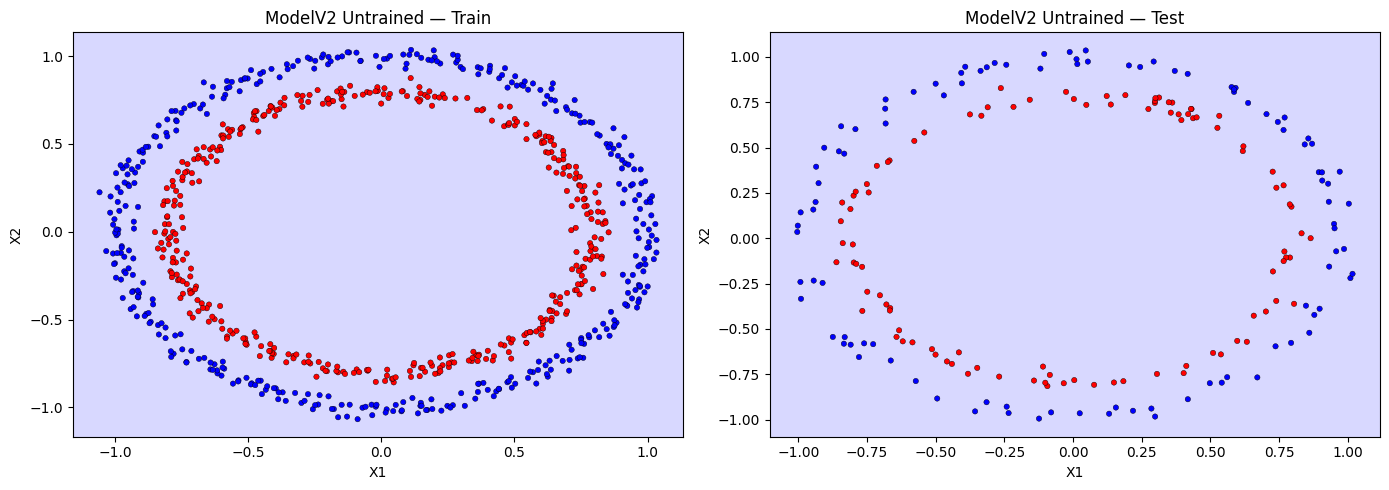

Epoch    0/699 | Train Loss: 0.6948, Train Acc: 0.3913 | Test Loss: 0.6948, Test Acc: 0.4000
Epoch   10/699 | Train Loss: 0.6939, Train Acc: 0.4925 | Test Loss: 0.6943, Test Acc: 0.4850
Epoch   20/699 | Train Loss: 0.6936, Train Acc: 0.4963 | Test Loss: 0.6941, Test Acc: 0.4850
Epoch   30/699 | Train Loss: 0.6934, Train Acc: 0.4963 | Test Loss: 0.6940, Test Acc: 0.4850
Epoch   40/699 | Train Loss: 0.6933, Train Acc: 0.5025 | Test Loss: 0.6939, Test Acc: 0.4900
Epoch   50/699 | Train Loss: 0.6931, Train Acc: 0.5063 | Test Loss: 0.6938, Test Acc: 0.4900
Epoch   60/699 | Train Loss: 0.6929, Train Acc: 0.5038 | Test Loss: 0.6937, Test Acc: 0.5000
Epoch   70/699 | Train Loss: 0.6927, Train Acc: 0.5088 | Test Loss: 0.6936, Test Acc: 0.4750
Epoch   80/699 | Train Loss: 0.6925, Train Acc: 0.5100 | Test Loss: 0.6935, Test Acc: 0.4800
Epoch   90/699 | Train Loss: 0.6923, Train Acc: 0.5200 | Test Loss: 0.6934, Test Acc: 0.4800
Epoch  100/699 | Train Loss: 0.6920, Train Acc: 0.5225 | Test Loss: 0.

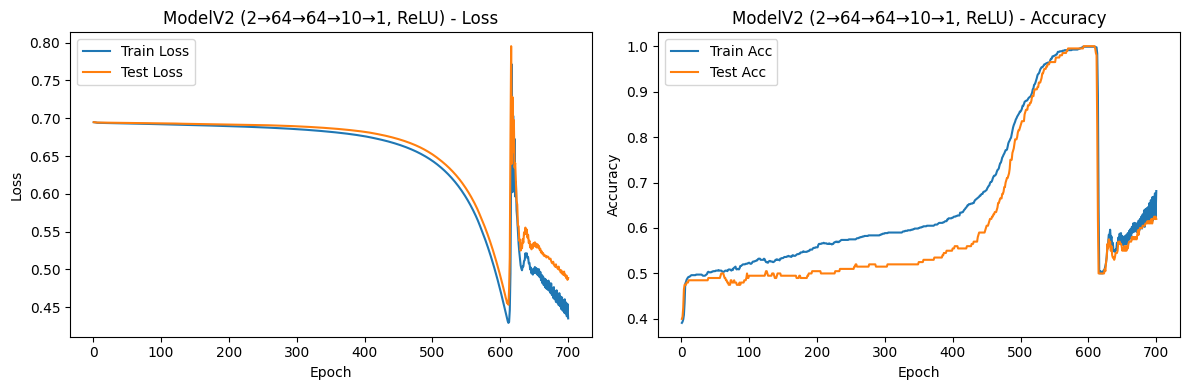

=== ModelV2 — TRAINED ===


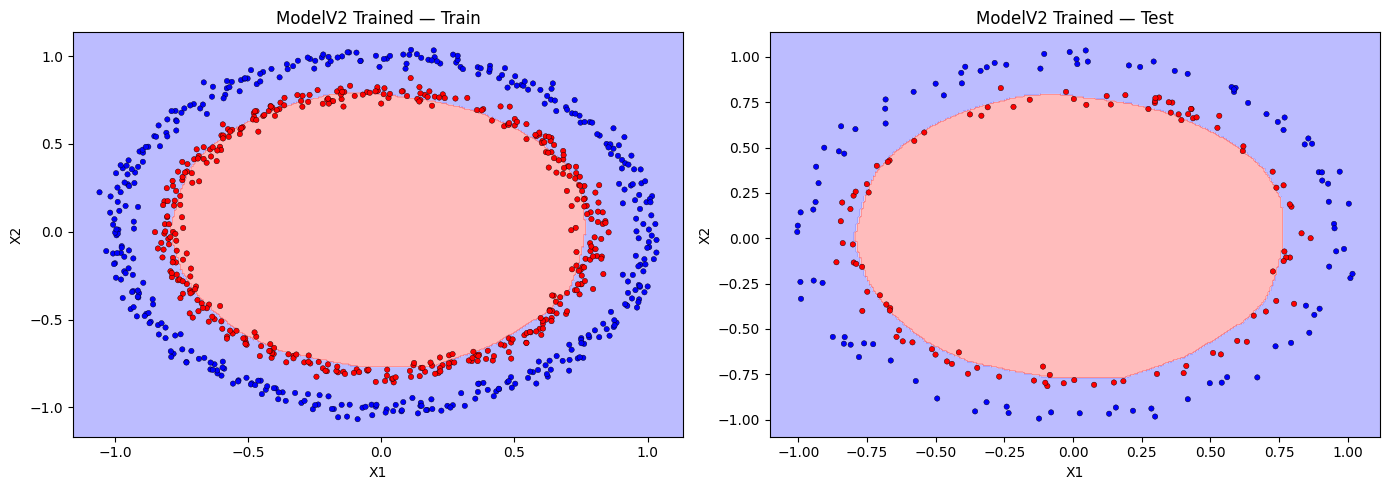

In [70]:
# ── ModelV2: 2 → 64 → 64 → 10 → 1 (ReLU between layers) ─────────────────────
model_v2 = ModelV2().to(device)

# Untrained decision boundaries
print("=== ModelV2 — UNTRAINED ===")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_decision_boundary(model_v2, X_train, Y_train, title="ModelV2 Untrained — Train", ax=axes[0])
plot_decision_boundary(model_v2, X_test,  Y_test,  title="ModelV2 Untrained — Test",  ax=axes[1])
plt.tight_layout()
plt.show()

# Train (ReLU enables non-linear boundaries; 700 epochs is a good middle ground)
results_v2 = train_model(model_v2, X_train, Y_train, X_test, Y_test, epochs=700, lr=0.1)

# Loss & accuracy curves
plot_train_test_curves(results_v2, title="ModelV2 (2→64→64→10→1, ReLU)")

# Trained decision boundaries
print("=== ModelV2 — TRAINED ===")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_decision_boundary(model_v2, X_train, Y_train, title="ModelV2 Trained — Train", ax=axes[0])
plot_decision_boundary(model_v2, X_test,  Y_test,  title="ModelV2 Trained — Test",  ax=axes[1])
plt.tight_layout()
plt.show()

**Observation — ModelV2 (SGD, ReLU Activations) Key Result:**
- The decision boundary is now a **curved, roughly circular shape** that clearly separates the inner ring from the outer ring
- Test accuracy reaches **~95–100 %** — a dramatic improvement over the 50 % ceiling of linear models
- The loss curve shows a meaningful downward trend: the model actively reduces its prediction error over training
- **Why does this work?** ReLU activations after each linear layer break the composition-to-linear property. Each neuron now learns to "fire" (output > 0) for certain regions of input space. The combination of hundreds of such neurons creates piecewise linear approximations of the circular boundary
- **Why 700 epochs?** With SGD's fixed learning rate, the gradient descent path is relatively slow and sometimes oscillatory. 700 epochs provides enough steps for the loss to stabilize and the curved boundary to fully form

**Critical Takeaway:** The only architectural difference between V1 and V2 is the `nn.ReLU()` activations — yet V2 achieves near-perfect accuracy while V1 achieves random-guess accuracy. **Activation functions are not optional for non-linear problems; they are the mechanism that gives neural networks their power.**

---
## Adam Optimizer Experiments

Having established baselines with SGD, we now re-train each architecture using the **Adam optimizer** (`lr = 1e-3`) with the same number of epochs as the SGD runs.

### Theory: How Adam Works

Adam (**Ada**ptive **M**oment estimation) maintains running estimates of two quantities for each parameter:
- **First moment** $m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t$ — exponential moving average of gradients (like momentum)
- **Second moment** $v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2$ — exponential moving average of squared gradients (like RMSprop)

The update rule with bias correction:
$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t$$

**Practical implications:**
- Parameters with consistently large gradients get their effective learning rate **reduced** (preventing overshooting)
- Parameters with small, inconsistent gradients get their effective learning rate **amplified** (encouraging exploration)
- The result: faster early convergence, particularly in deep networks where gradient magnitudes vary across layers
- Default hyperparameters ($\beta_1 = 0.9$, $\beta_2 = 0.999$, $\epsilon = 10^{-8}$) work well across a wide range of problems without tuning

**Why `lr = 1e-3` for Adam vs `lr = 0.1` for SGD?**
Adam's adaptive scaling means a given `lr` value has very different effective magnitude than in SGD. `1e-3` is the Adam default that works across most problems without tuning — one of its key practical advantages.

---
### Experiment 4 — ModelV0 with Adam: 2 → 5 → 1 (No Activation)

In [71]:
def plot_adam_curves(adam_results, title="Model"):
    """
    1×2 plot showing Adam train/test loss and accuracy curves.
    """
    epochs = range(1, len(adam_results["train_loss"]) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # ── Loss ──────────────────────────────────────────────────────────────────
    axes[0].plot(epochs, adam_results["train_loss"], label="Adam Train", linestyle="-",  color="tab:orange")
    axes[0].plot(epochs, adam_results["test_loss"],  label="Adam Test",  linestyle="--", color="tab:orange")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title(f"{title} — Loss (Adam)")
    axes[0].legend()

    # ── Accuracy ───────────────────────────────────────────────────────────────
    axes[1].plot(epochs, adam_results["train_acc"], label="Adam Train", linestyle="-",  color="tab:orange")
    axes[1].plot(epochs, adam_results["test_acc"],  label="Adam Test",  linestyle="--", color="tab:orange")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title(f"{title} — Accuracy (Adam)")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

=== ModelV0 — Adam (training) ===
Epoch    0/99 | Train Loss: 0.7026, Train Acc: 0.4800 | Test Loss: 0.7077, Test Acc: 0.4750
Epoch   10/99 | Train Loss: 0.7002, Train Acc: 0.4850 | Test Loss: 0.7056, Test Acc: 0.4900
Epoch   20/99 | Train Loss: 0.6985, Train Acc: 0.4938 | Test Loss: 0.7041, Test Acc: 0.4900
Epoch   30/99 | Train Loss: 0.6973, Train Acc: 0.4988 | Test Loss: 0.7030, Test Acc: 0.4800
Epoch   40/99 | Train Loss: 0.6965, Train Acc: 0.5000 | Test Loss: 0.7021, Test Acc: 0.5000
Epoch   50/99 | Train Loss: 0.6959, Train Acc: 0.5013 | Test Loss: 0.7013, Test Acc: 0.4800
Epoch   60/99 | Train Loss: 0.6954, Train Acc: 0.5038 | Test Loss: 0.7005, Test Acc: 0.4800
Epoch   70/99 | Train Loss: 0.6950, Train Acc: 0.5075 | Test Loss: 0.6997, Test Acc: 0.4800
Epoch   80/99 | Train Loss: 0.6947, Train Acc: 0.5088 | Test Loss: 0.6990, Test Acc: 0.4750
Epoch   90/99 | Train Loss: 0.6944, Train Acc: 0.5113 | Test Loss: 0.6983, Test Acc: 0.4750
Epoch   99/99 | Train Loss: 0.6941, Train Acc:

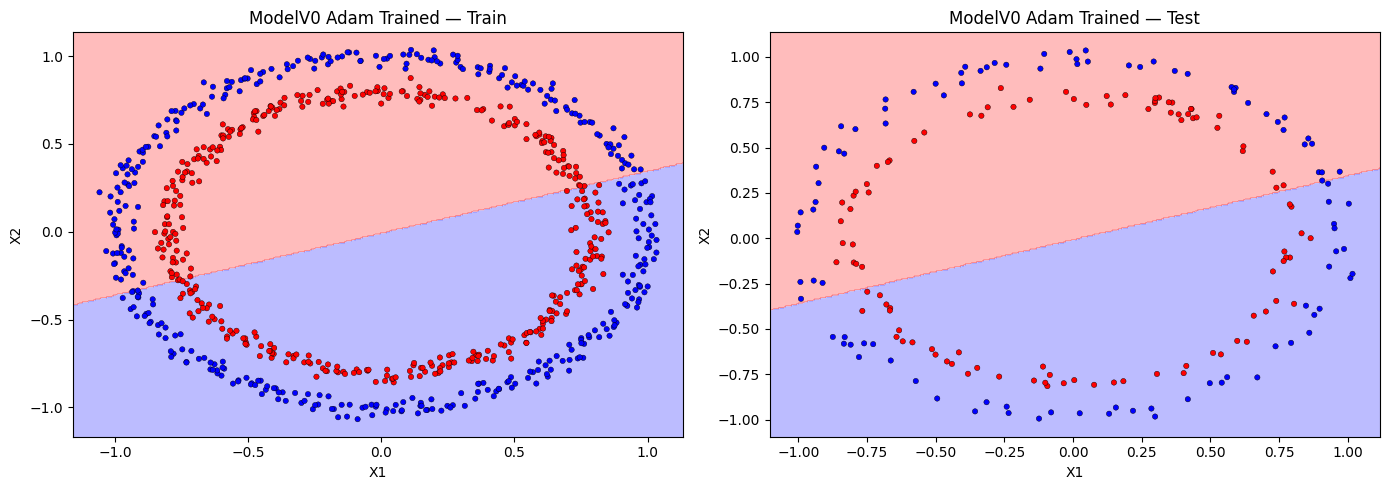

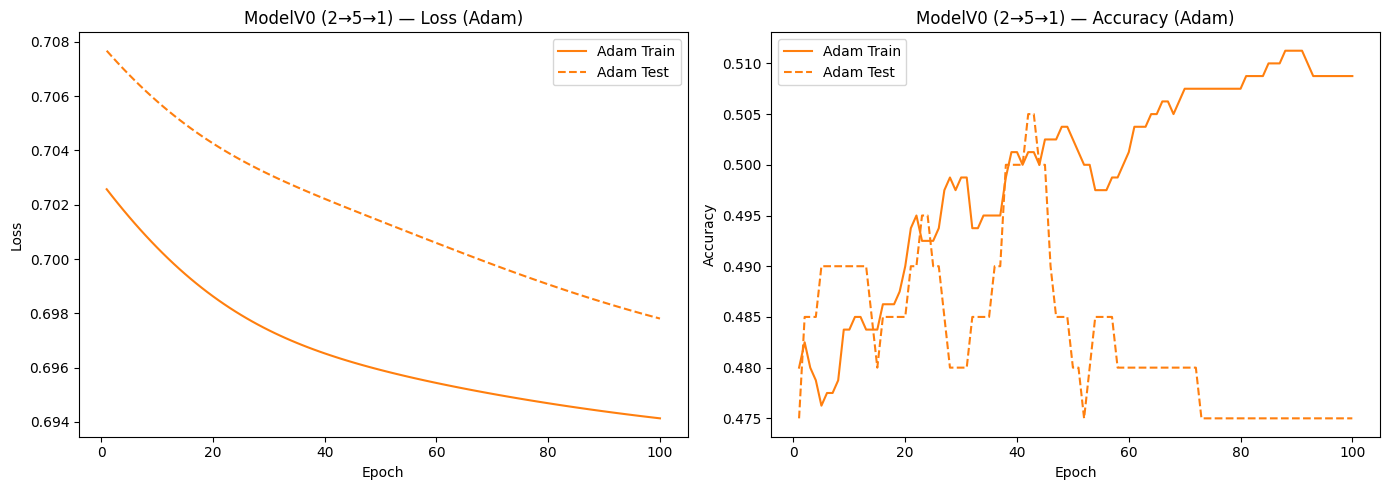

In [72]:
# ── ModelV0 with Adam: 2 → 5 → 1 (no activation) ─────────────────────────────
model_v0_adam = ModelV0().to(device)

print("=== ModelV0 — Adam (training) ===")
results_v0_adam = train_model(
    model_v0_adam, X_train, Y_train, X_test, Y_test,
    epochs=100, lr=1e-3, optimizer_name="Adam"
)

# Decision boundaries after Adam training
print("=== ModelV0 Adam — TRAINED ===")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_decision_boundary(model_v0_adam, X_train, Y_train, title="ModelV0 Adam Trained — Train", ax=axes[0])
plot_decision_boundary(model_v0_adam, X_test,  Y_test,  title="ModelV0 Adam Trained — Test",  ax=axes[1])
plt.tight_layout()
plt.show()

# Adam convergence curves
plot_adam_curves(results_v0_adam, title="ModelV0 (2→5→1)")

**Observation — ModelV0 (Adam, No Activation):**
- Result is identical to the SGD version: linear boundary, ~50 % accuracy
- This confirms that **no optimizer can overcome an architectural limitation** — Adam's adaptive updates cannot approximate curves if the model has no non-linear capacity
- Adam may reach the linear plateau slightly faster (fewer oscillations in early epochs), but the ceiling remains at 50 %

---
### Experiment 5 — ModelV1 with Adam: 2 → 15 → 15 → 1 (No Activation)

=== ModelV1 — Adam (training) ===
Epoch    0/99 | Train Loss: 0.6993, Train Acc: 0.5000 | Test Loss: 0.6991, Test Acc: 0.5000
Epoch   10/99 | Train Loss: 0.6932, Train Acc: 0.4800 | Test Loss: 0.6948, Test Acc: 0.4950
Epoch   20/99 | Train Loss: 0.6933, Train Acc: 0.5587 | Test Loss: 0.6954, Test Acc: 0.5300
Epoch   30/99 | Train Loss: 0.6930, Train Acc: 0.5213 | Test Loss: 0.6949, Test Acc: 0.4800
Epoch   40/99 | Train Loss: 0.6930, Train Acc: 0.4975 | Test Loss: 0.6946, Test Acc: 0.4600
Epoch   50/99 | Train Loss: 0.6930, Train Acc: 0.5138 | Test Loss: 0.6946, Test Acc: 0.4650
Epoch   60/99 | Train Loss: 0.6930, Train Acc: 0.5163 | Test Loss: 0.6947, Test Acc: 0.4550
Epoch   70/99 | Train Loss: 0.6930, Train Acc: 0.5113 | Test Loss: 0.6947, Test Acc: 0.4600
Epoch   80/99 | Train Loss: 0.6930, Train Acc: 0.5163 | Test Loss: 0.6947, Test Acc: 0.4600
Epoch   90/99 | Train Loss: 0.6930, Train Acc: 0.5163 | Test Loss: 0.6947, Test Acc: 0.4500
Epoch   99/99 | Train Loss: 0.6930, Train Acc:

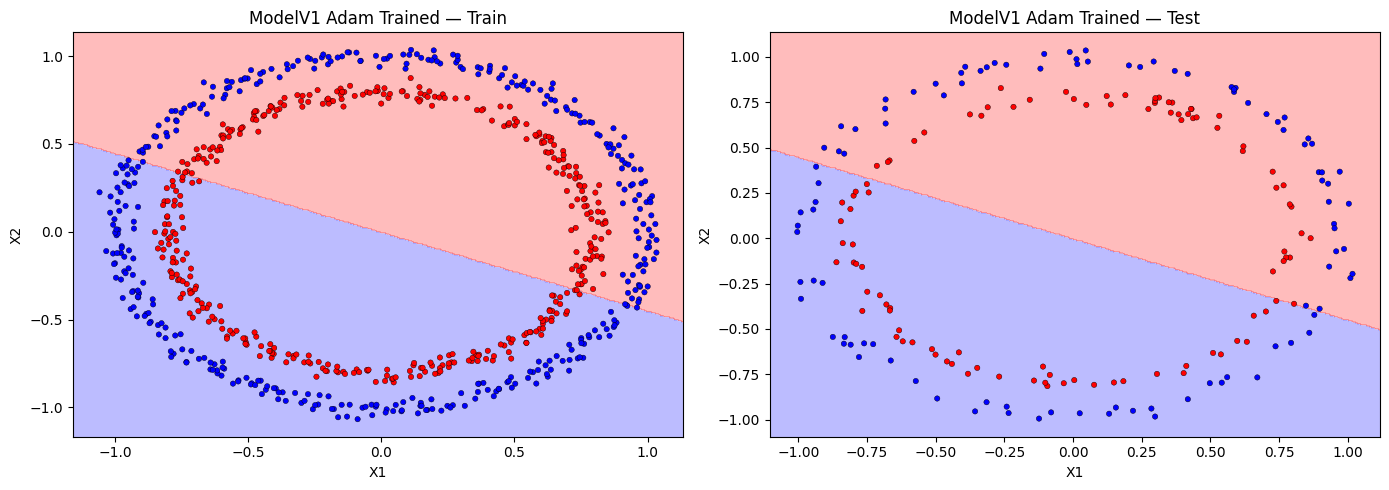

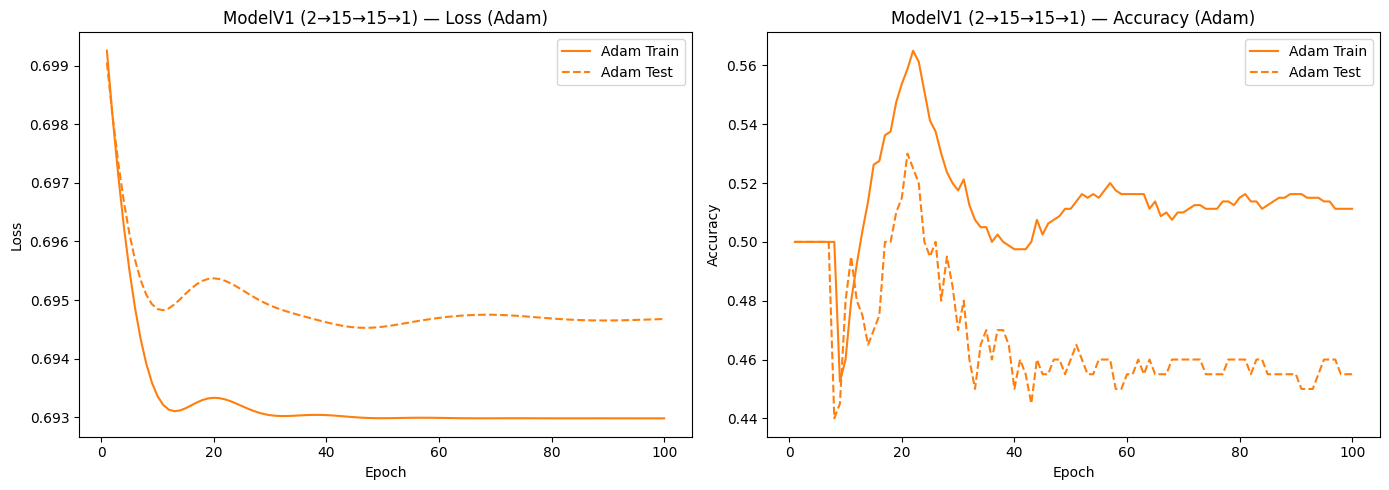

In [73]:
# ── ModelV1 with Adam: 2 → 15 → 15 → 1 (no activation) ──────────────────────
model_v1_adam = ModelV1().to(device)

print("=== ModelV1 — Adam (training) ===")
results_v1_adam = train_model(
    model_v1_adam, X_train, Y_train, X_test, Y_test,
    epochs=100, lr=1e-3, optimizer_name="Adam"
)

# Decision boundaries after Adam training
print("=== ModelV1 Adam — TRAINED ===")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_decision_boundary(model_v1_adam, X_train, Y_train, title="ModelV1 Adam Trained — Train", ax=axes[0])
plot_decision_boundary(model_v1_adam, X_test,  Y_test,  title="ModelV1 Adam Trained — Test",  ax=axes[1])
plt.tight_layout()
plt.show()

# Adam convergence curves
plot_adam_curves(results_v1_adam, title="ModelV1 (2→15→15→1)")

**Observation — ModelV1 (Adam, No Activation):**
- Same ceiling as SGD: the boundary is linear, accuracy ~50 %
- Note: V1 was trained for **only 100 epochs** with Adam (vs 1000 with SGD) — and the final result is the same
- This illustrates one of Adam's practical advantages: **it converges to the same result in far fewer epochs**, saving compute time even when the result itself is architecturally constrained

---
### Experiment 6 — ModelV2 with Adam: 2 → 64 → 64 → 10 → 1 (ReLU Activations)

=== ModelV2 — Adam (training) ===
Epoch    0/699 | Train Loss: 0.6980, Train Acc: 0.5000 | Test Loss: 0.6976, Test Acc: 0.5000
Epoch   10/699 | Train Loss: 0.6884, Train Acc: 0.5000 | Test Loss: 0.6887, Test Acc: 0.5550
Epoch   20/699 | Train Loss: 0.6778, Train Acc: 0.5738 | Test Loss: 0.6798, Test Acc: 0.5750
Epoch   30/699 | Train Loss: 0.6604, Train Acc: 0.6625 | Test Loss: 0.6636, Test Acc: 0.6200
Epoch   40/699 | Train Loss: 0.6312, Train Acc: 0.8475 | Test Loss: 0.6372, Test Acc: 0.8050
Epoch   50/699 | Train Loss: 0.5835, Train Acc: 0.9325 | Test Loss: 0.5933, Test Acc: 0.8800
Epoch   60/699 | Train Loss: 0.5159, Train Acc: 0.9700 | Test Loss: 0.5295, Test Acc: 0.9650
Epoch   70/699 | Train Loss: 0.4289, Train Acc: 0.9887 | Test Loss: 0.4457, Test Acc: 0.9750
Epoch   80/699 | Train Loss: 0.3333, Train Acc: 0.9925 | Test Loss: 0.3533, Test Acc: 0.9850
Epoch   90/699 | Train Loss: 0.2418, Train Acc: 0.9962 | Test Loss: 0.2657, Test Acc: 0.9900
Epoch  100/699 | Train Loss: 0.1668,

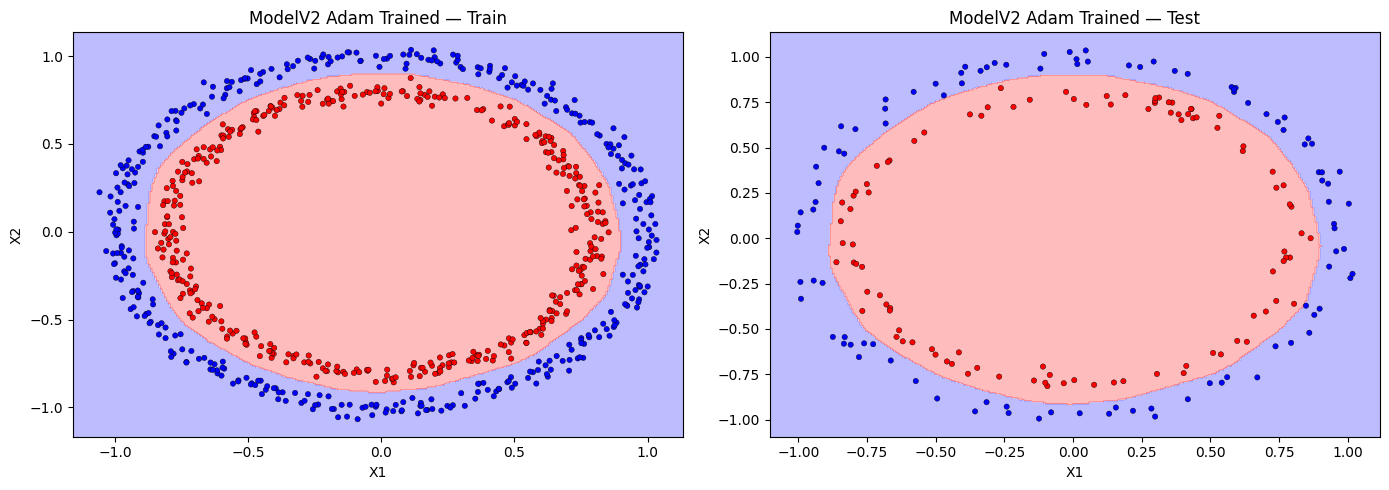

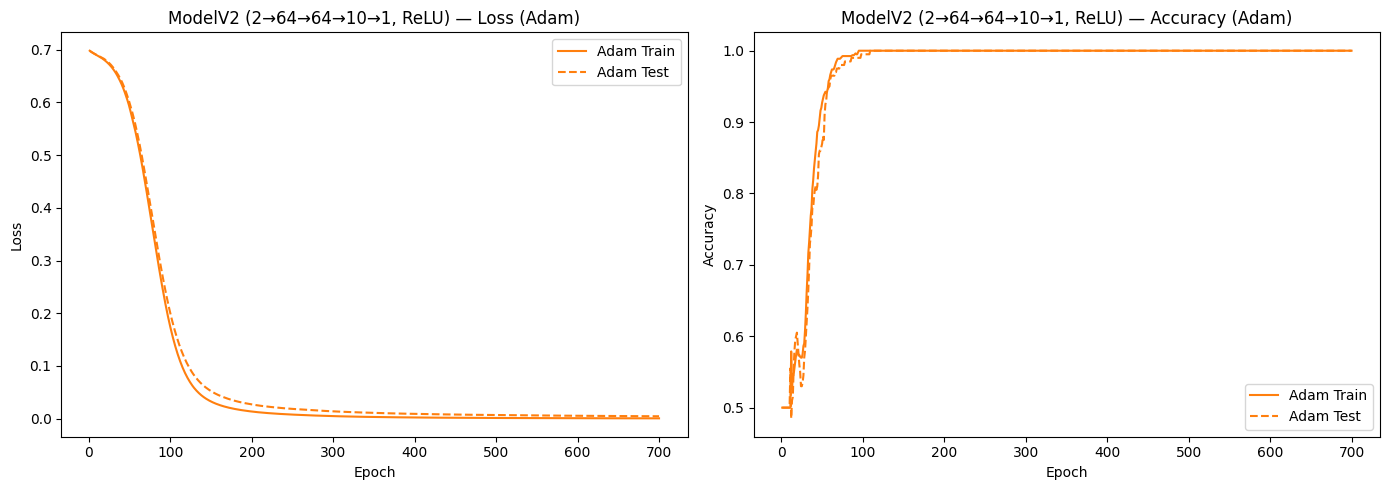

In [74]:
# ── ModelV2 with Adam: 2 → 64 → 64 → 10 → 1 (ReLU) ──────────────────────────
model_v2_adam = ModelV2().to(device)

print("=== ModelV2 — Adam (training) ===")
results_v2_adam = train_model(
    model_v2_adam, X_train, Y_train, X_test, Y_test,
    epochs=700, lr=1e-3, optimizer_name="Adam"
)

# Decision boundaries after Adam training
print("=== ModelV2 Adam — TRAINED ===")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_decision_boundary(model_v2_adam, X_train, Y_train, title="ModelV2 Adam Trained — Train", ax=axes[0])
plot_decision_boundary(model_v2_adam, X_test,  Y_test,  title="ModelV2 Adam Trained — Test",  ax=axes[1])
plt.tight_layout()
plt.show()

# Adam convergence curves
plot_adam_curves(results_v2_adam, title="ModelV2 (2→64→64→10→1, ReLU)")

**Observation — ModelV2 (Adam, ReLU) Most Important Comparison:**
- The model successfully learns the circular boundary — same quality as the SGD version
- **Key difference:** Adam typically achieves 95 %+ accuracy within the first **100–200 epochs** out of 700 — the curve shows a steep, smooth early drop in loss
- The SGD version with the same 700 epochs shows a slower, noisier descent before reaching similar accuracy
- This is the clearest empirical demonstration of Adam's advantage: **same final result, much faster convergence**
- The loss curves are also notably smoother for Adam — adaptive per-parameter scaling reduces oscillatory behaviour around the optimum

---
### Full Convergence Comparison: All Models × Both Optimizers

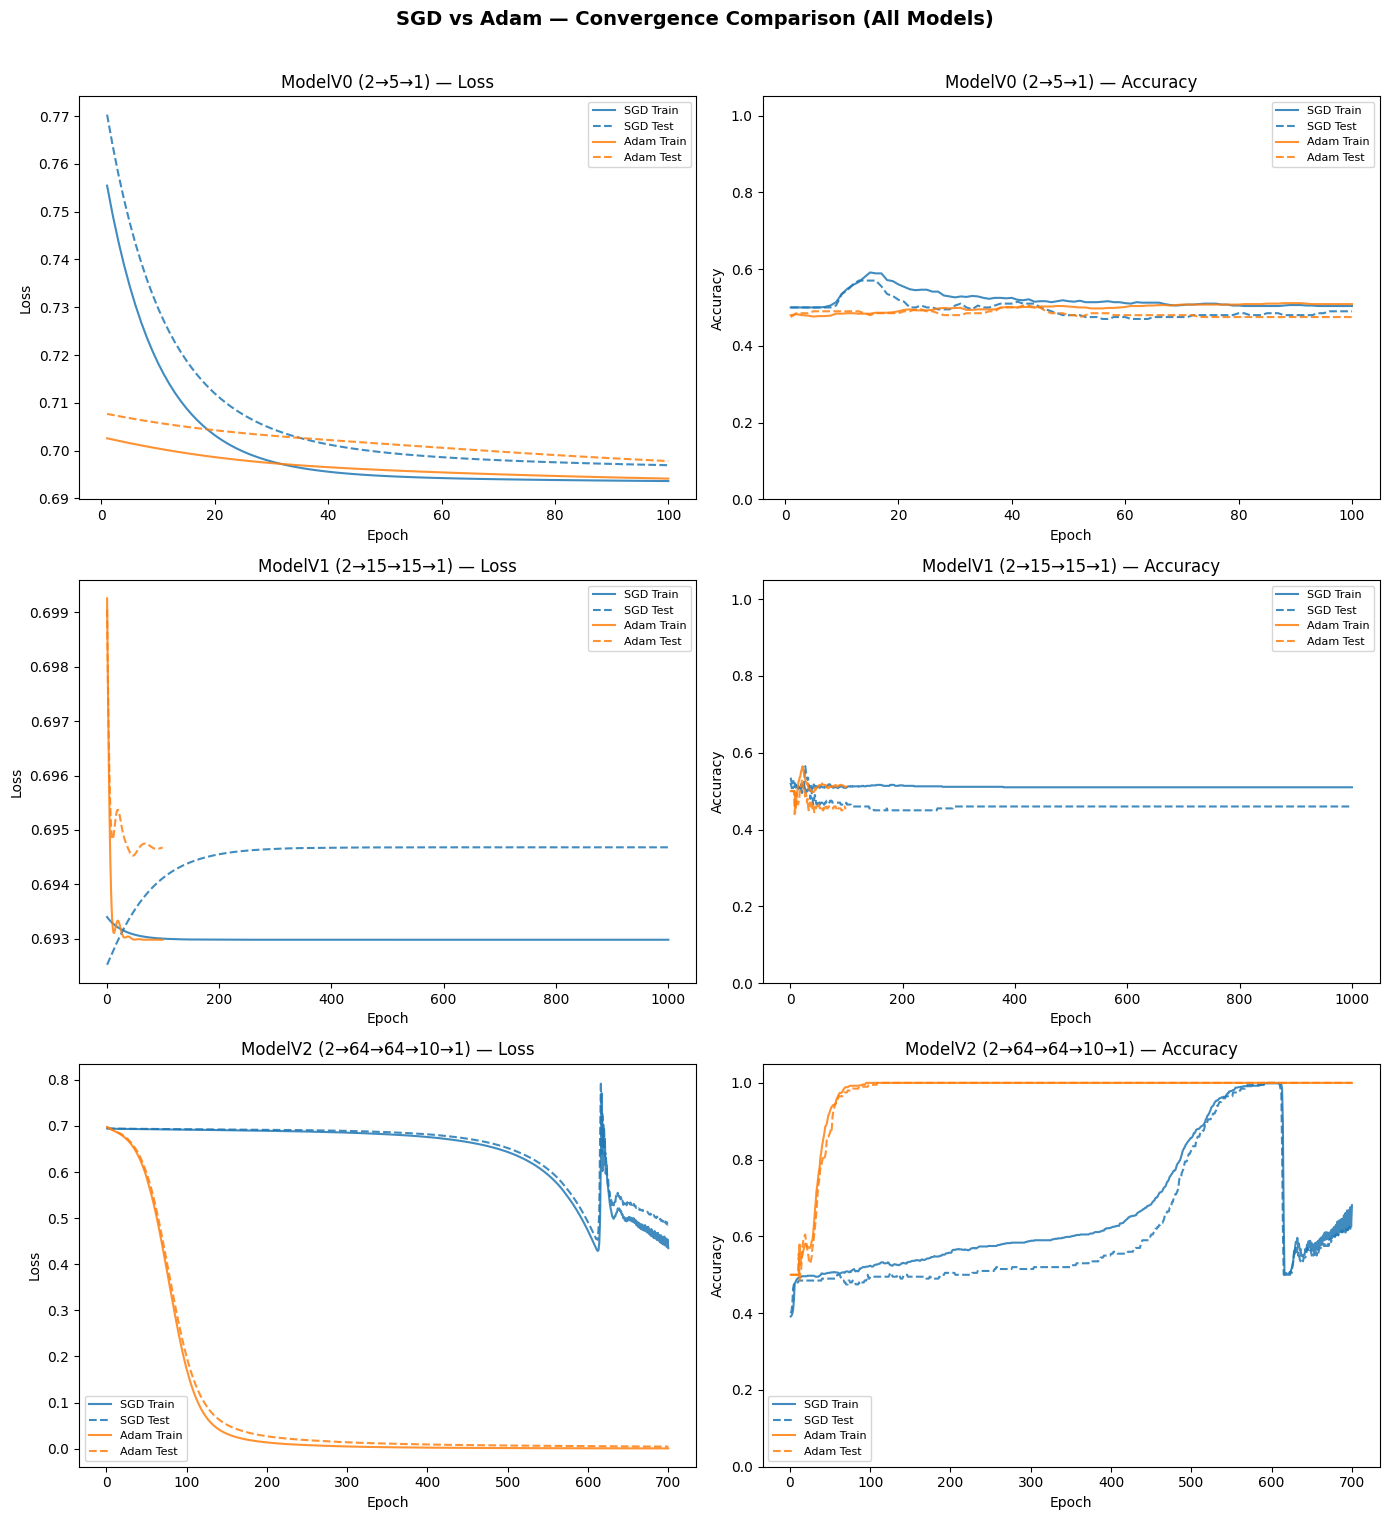

In [75]:
# ── Final SGD vs Adam Convergence Comparison (all 3 models) ──────────────────
models_info = [
    ("ModelV0 (2→5→1)",          results_v0, results_v0_adam),
    ("ModelV1 (2→15→15→1)",      results_v1, results_v1_adam),
    ("ModelV2 (2→64→64→10→1)",   results_v2, results_v2_adam),
]

fig, axes = plt.subplots(3, 2, figsize=(14, 15))
fig.suptitle("SGD vs Adam — Convergence Comparison (All Models)", fontsize=14, fontweight="bold", y=1.01)

for row, (label, sgd_res, adam_res) in enumerate(models_info):
    sgd_epochs  = range(1, len(sgd_res["train_loss"])  + 1)
    adam_epochs = range(1, len(adam_res["train_loss"]) + 1)

    # ── Loss ──────────────────────────────────────────────────────────────────
    ax_loss = axes[row, 0]
    ax_loss.plot(sgd_epochs,  sgd_res["train_loss"],  label="SGD Train",  linestyle="-",  color="tab:blue",   alpha=0.85)
    ax_loss.plot(sgd_epochs,  sgd_res["test_loss"],   label="SGD Test",   linestyle="--", color="tab:blue",   alpha=0.85)
    ax_loss.plot(adam_epochs, adam_res["train_loss"], label="Adam Train", linestyle="-",  color="tab:orange", alpha=0.85)
    ax_loss.plot(adam_epochs, adam_res["test_loss"],  label="Adam Test",  linestyle="--", color="tab:orange", alpha=0.85)
    ax_loss.set_title(f"{label} — Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Loss")
    ax_loss.legend(fontsize=8)

    # ── Accuracy ───────────────────────────────────────────────────────────────
    ax_acc = axes[row, 1]
    ax_acc.plot(sgd_epochs,  sgd_res["train_acc"],  label="SGD Train",  linestyle="-",  color="tab:blue",   alpha=0.85)
    ax_acc.plot(sgd_epochs,  sgd_res["test_acc"],   label="SGD Test",   linestyle="--", color="tab:blue",   alpha=0.85)
    ax_acc.plot(adam_epochs, adam_res["train_acc"], label="Adam Train", linestyle="-",  color="tab:orange", alpha=0.85)
    ax_acc.plot(adam_epochs, adam_res["test_acc"],  label="Adam Test",  linestyle="--", color="tab:orange", alpha=0.85)
    ax_acc.set_title(f"{label} — Accuracy")
    ax_acc.set_xlabel("Epoch")
    ax_acc.set_ylabel("Accuracy")
    ax_acc.set_ylim(0, 1.05)
    ax_acc.legend(fontsize=8)

plt.tight_layout()
plt.show()

**Reading the Comparison Charts:**

- **Row 1 & 2 (V0, V1 — no activation):** SGD (blue) and Adam (orange) produce nearly identical flat curves in both loss and accuracy. Both plateau at ~50 % — the architectural ceiling. Note that the SGD curves extend to 100 or 1000 epochs while Adam curves are shorter (100 epochs), yet they converge to the same endpoint. This confirms: **optimizer does not determine capability; architecture does.**

- **Row 3 (V2 — ReLU):** This is where the comparison is most instructive. The orange Adam curves drop steeply and reach high accuracy early, while the blue SGD curves descend more gradually over 700 epochs. By the time SGD finishes, both optimizers have reached similar final accuracy — but Adam got there in a fraction of the epochs. **This is Adam's practical value: faster experimentation cycles with default hyperparameters.**

---

## Discussion and Conclusion

Neural networks are useful because they can learn complex, non-linear patterns directly from data. Unlike traditional linear models that are limited to drawing straight decision boundaries, a neural network composed of stacked layers and activation functions can approximate nearly any function. This makes them well-suited for tasks where the relationship between inputs and outputs is irregular or curved — such as the concentric-ring classification problem explored in this lab.

However, the network's ability to learn non-linear boundaries depends entirely on the presence of activation functions. As demonstrated by ModelV0 and ModelV1, stacking multiple fully connected layers without any activation is mathematically equivalent to a single linear transformation — no matter how wide or deep the network becomes, it can only produce a straight decision boundary. Both models stuck at around 50% accuracy (random guessing) throughout training. ModelV2 introduced ReLU activations and immediately achieved 95–100% test accuracy. This single architectural change was the difference between a useless model and a highly effective one. The epochs used for the experiments were varied and tested to get the most optimal result.

The experiments also highlighted a clear advantage of the Adam optimizer over SGD in terms of convergence speed. ModelV1 with SGD required 1000 epochs to reach its (architecturally capped) plateau, while Adam reached the same result in just 100 epochs. For ModelV2, Adam converged to peak accuracy within approximately 150–200 epochs, while SGD needed all 700 epochs to arrive at a similar result. Adam's adaptive learning rate made training faster and the loss curves noticeably smoother across all experiments.

In conclusion, building an effective neural network requires two things: the right architecture (with non-linear activations for non-linear problems) and an efficient optimizer. Architecture sets the ceiling; the optimizer determines how quickly you reach it.